In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import re

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

from collections import Counter

from tqdm.notebook import tqdm

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


/kaggle/input/kaggle-competition-2/train_results.csv
/kaggle/input/kaggle-competition-2/train_data.csv
/kaggle/input/kaggle-competition-2/test_data.csv


In [2]:
train_data = pd.read_csv("../input/kaggle-competition-2/train_data.csv").drop(columns=["id"])
train_labels = pd.read_csv("../input/kaggle-competition-2/train_results.csv").drop(columns=["id"])
test_data = pd.read_csv("../input/kaggle-competition-2/test_data.csv").drop(columns=["id"])

In [3]:
print(len(train_data), len(train_labels))
keep_index_train = train_data.drop_duplicates().index.tolist()
train_data = train_data.iloc[keep_index_train].reset_index()
train_labels = train_labels.iloc[keep_index_train].reset_index()
print(len(train_data), len(train_labels))

1040323 1040323
1030487 1030487


In [4]:
def transform_label_to_numeric(label) :
    if label == "negative" :
        return 0
    elif label == "neutral" :
        return 1
    return 2

In [5]:
train_labels["target"] = train_labels["target"].apply(lambda x : transform_label_to_numeric(x))
train_labels

,index,target
0,0,2
1,1,0
2,2,2
3,3,2
4,4,0
...,...,...
1030482,1040318,2
1030483,1040319,0
1030484,1040320,0
1030485,1040321,2


In [6]:
neg_percentage = len(np.where(train_labels["target"] == 0)[0])/len(train_labels["target"])*100
neut_percentage = len(np.where(train_labels["target"] == 1)[0])/len(train_labels["target"])*100
pos_percentage = len(np.where(train_labels["target"] == 2)[0])/len(train_labels["target"])*100
print(pos_percentage)
print(neg_percentage)
print(neut_percentage)

50.11591606686936
49.875932447473865
0.008151485656781697


In [7]:
def normalisation(message):
    message = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL', message)
    message = re.sub('@[^\s]+','USER', message)
    message = message.lower()
    message = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', message) 
    message = re.sub(' +',' ', message)
    message = re.sub(r'([?ahijquvwxy])\1+', lambda g:f'{g.group(0)[1]}', message)
    message = re.sub(r'([?bcdefgklmnoprstz])\1{2,}', lambda g:f'{g.group(0)[1]}', message)
    return message.strip()

stopWords = stopwords.words('english')
def erase_stopwords(message) :
    return ' '.join([mot for mot in message.split() if mot not in (stopWords)])

stemmer = SnowballStemmer('english')
def stemmisation(message) :
    return ' '.join([stemmer.stem(mot) for mot in message.split()])

lemmatizer = WordNetLemmatizer()
def lemmatisation(message) :
    return ' '.join([lemmatizer.lemmatize(mot) for mot in message.split(' ')])

def pre_processing(message, norm=True, sw=True, lemm=True, stemm=True) :
    if norm : 
        message = normalisation(message)
    if sw :
        message = erase_stopwords(message)
    if lemm :
        message = lemmatisation(message)
    if stemm :
        message = stemmisation(message)
    return message

# 1) Normalisation

In [8]:
train_data1 = train_data.copy()
test_data1 = test_data.copy()

In [9]:
train_data1["text"] = train_data["text"].apply(lambda m : pre_processing(m, sw=False, lemm=False, stemm=False))
test_data1["text"] = test_data["text"].apply(lambda m : pre_processing(m, sw=False, lemm=False, stemm=False))

train_data1

,index,text
0,0,anyway im getting of for a while
1,1,my red apache isn t feelin too well this morni...
2,2,user you should be its great friday will be gr...
3,3,its 11 3 pm and i dont wanna sleep so i debate...
4,4,why does twitter eat my dm s not happy
...,...,...
1030482,1040318,getting ready 2 watch mental
1030483,1040319,wristcutters and half nelson are on sundance f...
1030484,1040320,user going out in northbridge makes me jealous...
1030485,1040321,user lol gorgeous lol u look so much like that...


In [10]:
counter1 = Counter()
for i in train_data1["text"] :
    counter1.update(i.split(" "))
print(len(counter1))

vocab1 = list(counter1.keys())

t_data1, v_data1, t_labels1, v_labels1 = train_test_split(train_data1, train_labels, test_size=0.2, random_state=42)

190318


In [45]:
class MLP(nn.Module) :
    
    def __init__(self, dims, counter, max_features, activation_str = "sigmoid") :
        super(MLP, self).__init__()

        self.dims = dims
        self.n_hidden = len(dims) - 2
        self.activation_str = activation_str
        
        self.max_features = max_features
        self.vocab = [i[0] for i in counter.most_common(max_features)]
        self.count = CountVectorizer(vocabulary=self.vocab, ngram_range=(1, 2))
        self.transform = TfidfTransformer()

        self.layers = []
        for i in range(self.n_hidden + 1) :
            self.layers.append(nn.Linear(self.dims[i], self.dims[i+1]))
            if i == self.n_hidden :
                self.layers.append(nn.Softmax())
            else :
                if self.activation_str == "sigmoid" :
                    self.layers.append(nn.Sigmoid())
                elif self.activation_str == "relu":
                    self.layers.append(nn.ReLU())
                elif self.activation_str == "tanh":
                    self.layers.append(nn.Tanh())
                else:
                    raise Exception("Invalid activation")
            
        self.model = nn.Sequential(*self.layers)
        
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters())
        
    def encode_BOF(self, data, fit) :
        # Encode text to BOF with our extract vocabulary
        if fit :
            bow = self.count.fit_transform(data["text"])
            bow = self.transform.fit_transform(bow)
        else :
            bow = self.count.transform(data["text"])
            bow = self.transform.transform(bow)
        return torch.tensor(bow.toarray(), dtype=torch.float)
    
    def train_loop(self, epoch, train_data, train_labels, bs=10000) :
        # Train(fit) on batch of size bs
        train_acc = 0.
        train_loss = 0.
        l = len(train_data)
        for i in tqdm(range(0, l, bs)):
            inputs = self.encode_BOF(train_data.iloc[i:i+bs], True)
            labels = torch.tensor(np.array(train_labels.iloc[i:i+bs]["target"]))
            inputs, labels = inputs.to(device), labels.to(device)
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            train_loss += loss.item()
            train_acc += float(torch.sum(torch.argmax(outputs, dim=1) == labels))
            self.optimizer.step()
        train_loss, train_acc = train_loss / (l//bs), train_acc / l

        print(f"Epoch: {epoch} | Train Acc: {train_acc:.6f} | Train Loss: {train_loss:.6f}")
        return train_acc, train_loss
    
    def valid_loop(self, epoch, val_data, val_labels, bs=10000):
        val_acc = 0.
        val_loss = 0.
        model.eval()
        l = len(val_data)
        with torch.no_grad():
            for i in tqdm(range(0, l, bs)):
                inputs = self.encode_BOF(val_data.iloc[i:i+bs], False)
                labels = torch.tensor(np.array(val_labels.iloc[i:i+bs]["target"]))
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                val_loss += loss.item()
                val_acc += float(torch.sum(torch.argmax(outputs, dim=1) == labels))
        val_loss, val_acc = val_loss / (l//bs), val_acc / l

        print(f"Epoch: {epoch} | Val Acc: {val_acc:.6f}   | Val Loss: {val_loss:.6f}")
        return val_acc, val_loss

In [29]:
train_accuracies, train_losses, val_accuracies, val_losses = [], [], [], []
nb_features1 = list(range(1000, 6000, 1000)) + list(range(10000, 25000, 5000)) + list(range(30000, 50000, 10000))
for i in tqdm(nb_features1) :
    t_accs, t_losses, v_accs, v_losses = [], [], [], []
    n_epochs = 15
    
    model = MLP((i, i//10, i//100, 3), counter1, i).to(device)

    for epoch in range(n_epochs):
        # Training
        t_acc, t_loss = model.train_loop(epoch, t_data1, t_labels1, bs=5000)
        t_accs.append(t_acc)
        t_losses.append(t_loss)

        # Validation
        v_acc, v_loss = model.valid_loop(epoch, v_data1, v_labels1, bs=5000)
        v_accs.append(v_acc)
        v_losses.append(v_loss)
        
    train_accuracies.append(t_accs)
    train_losses.append(t_losses)
    val_accuracies.append(v_accs)
    val_losses.append(v_losses)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Val Acc: 0.499199   | Val Loss: 1.000860
Epoch: 1 | Val Acc: 0.739236   | Val Loss: 0.967226
Epoch: 2 | Val Acc: 0.752914   | Val Loss: 0.870894
Epoch: 3 | Val Acc: 0.763176   | Val Loss: 0.819430
Epoch: 4 | Val Acc: 0.766703   | Val Loss: 0.806380
Epoch: 5 | Val Acc: 0.768411   | Val Loss: 0.800541
Epoch: 6 | Val Acc: 0.769246   | Val Loss: 0.797620
Epoch: 7 | Val Acc: 0.770109   | Val Loss: 0.796011
Epoch: 8 | Val Acc: 0.770386   | Val Loss: 0.795035
Epoch: 9 | Val Acc: 0.770410   | Val Loss: 0.794394
Epoch: 10 | Val Acc: 0.770629   | Val Loss: 0.793941
Epoch: 11 | Val Acc: 0.770823   | Val Loss: 0.793602
Epoch: 12 | Val Acc: 0.770794   | Val Loss: 0.793336
Epoch: 13 | Val Acc: 0.770939   | Val Loss: 0.793122
Epoch: 14 | Val Acc: 0.771046   | Val Loss: 0.792947
Epoch: 0 | Val Acc: 0.743307   | Val Loss: 0.981053
Epoch: 1 | Val Acc: 0.765427   | Val Loss: 0.851059
Epoch: 2 | Val Acc: 0.777717   | Val Loss: 0.795108
Epoch: 3 | Val Acc: 0.780667   | Val Loss: 0.786016
Epoch: 

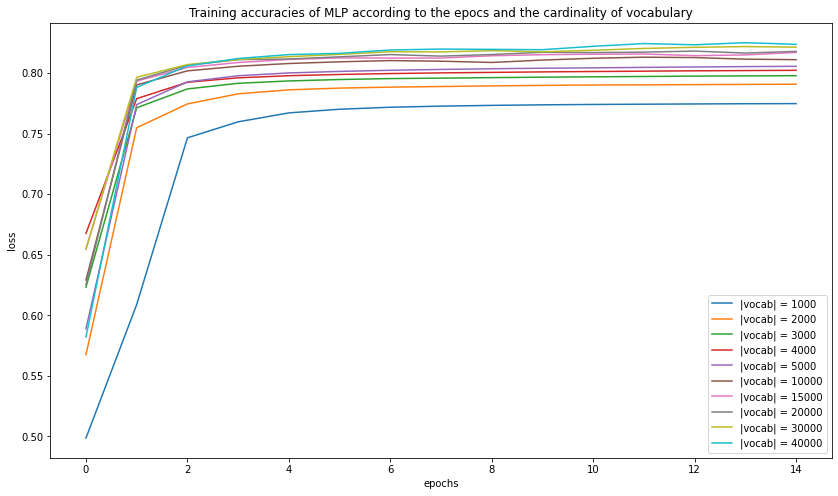

In [36]:
plt.figure(figsize = [14, 8])
for i in range(len(train_accuracies)) :
    plt.plot(range(n_epochs), train_accuracies[i], label = "|vocab| = " + str(nb_features1[i]))
    plt.title("Training accuracies of MLP according to the epocs and the cardinality of vocabulary")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

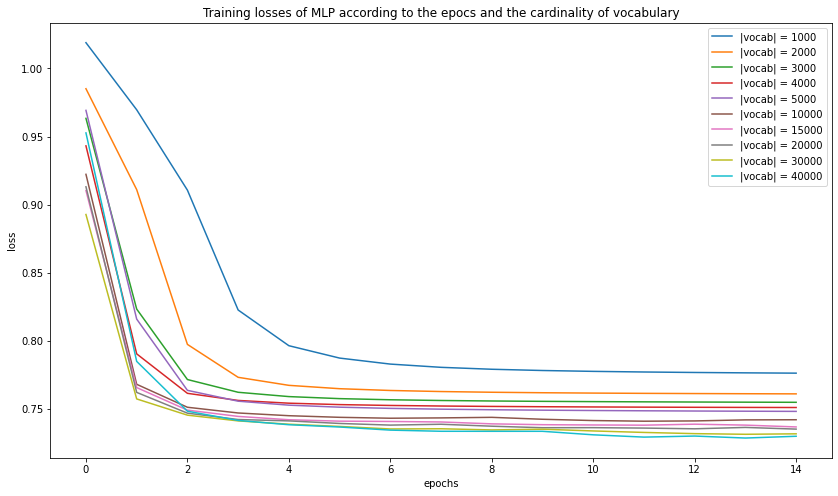

In [37]:
plt.figure(figsize = [14, 8])
for i in range(len(train_losses)) :
    plt.plot(range(n_epochs), train_losses[i], label = "|vocab| = " + str(nb_features1[i]))
    plt.title("Training losses of MLP according to the epocs and the cardinality of vocabulary")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

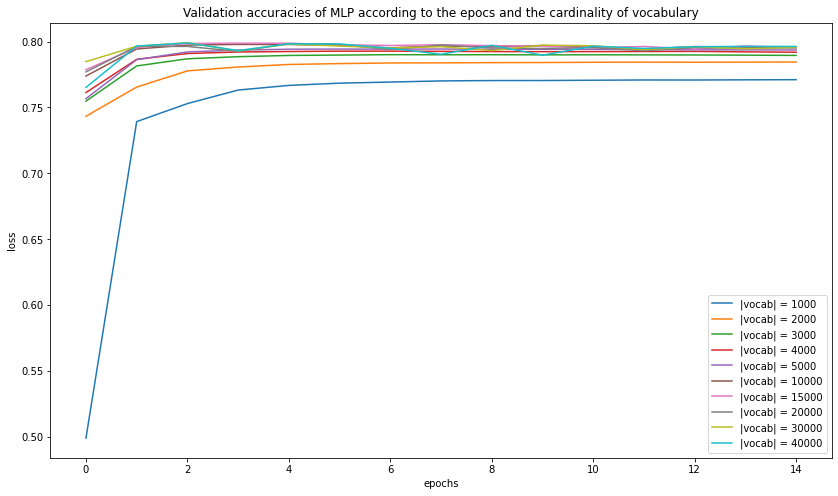

In [38]:
plt.figure(figsize = [14, 8])
for i in range(len(val_accuracies)) :
    plt.plot(range(n_epochs), val_accuracies[i], label = "|vocab| = " + str(nb_features1[i]))
    plt.title("Validation accuracies of MLP according to the epocs and the cardinality of vocabulary")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

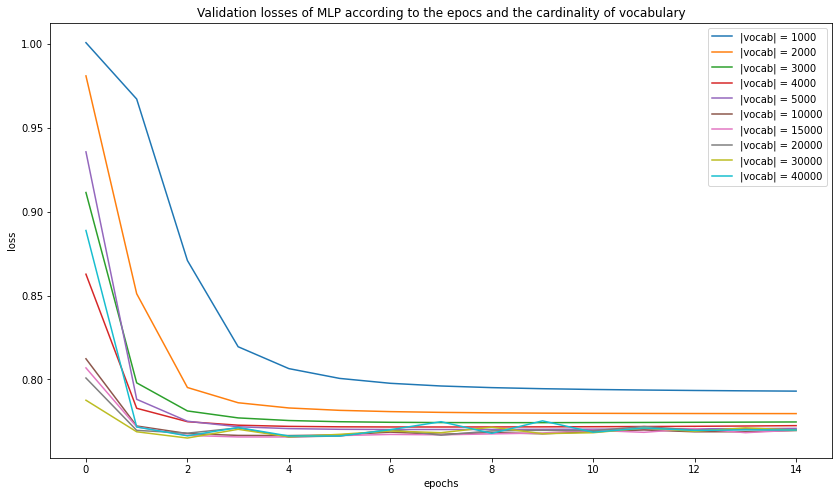

In [40]:
plt.figure(figsize = [14, 8])
for i in range(len(val_losses)) :
    plt.plot(range(n_epochs), val_losses[i], label = "|vocab| = " + str(nb_features1[i]))
    plt.title("Validation losses of MLP according to the epocs and the cardinality of vocabulary")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

# 2) Normalisation + Lemmisation

In [41]:
train_data2 = train_data.copy()
test_data2 = test_data.copy()

In [42]:
train_data2["text"] = train_data["text"].apply(lambda m : pre_processing(m, sw=False, stemm=False))
test_data2["text"] = test_data["text"].apply(lambda m : pre_processing(m, sw=False, stemm=False))

train_data2

,index,text
0,0,anyway im getting of for a while
1,1,my red apache isn t feelin too well this morni...
2,2,user you should be it great friday will be gre...
3,3,it 11 3 pm and i dont wanna sleep so i debated...
4,4,why doe twitter eat my dm s not happy
...,...,...
1030482,1040318,getting ready 2 watch mental
1030483,1040319,wristcutters and half nelson are on sundance f...
1030484,1040320,user going out in northbridge make me jealous ...
1030485,1040321,user lol gorgeous lol u look so much like that...


In [43]:
counter2 = Counter()
for i in train_data2["text"] :
    counter2.update(i.split(" "))
print(len(counter2))

vocab2 = list(counter2.keys())

t_data2, v_data2, t_labels2, v_labels2 = train_test_split(train_data2, train_labels, test_size=0.2, random_state=42)

180747


In [46]:
t_accs, t_losses, v_accs, v_losses = [], [], [], []
n_epochs = 10

model = MLP((15000, 1500, 150, 3), counter2, 15000).to(device)

for epoch in range(n_epochs):
    # Training
    t_acc, t_loss = model.train_loop(epoch, t_data2, t_labels2, bs=4096)
    t_accs.append(t_acc)
    t_losses.append(t_loss)

    # Validation
    v_acc, v_loss = model.valid_loop(epoch, v_data2, v_labels2, bs=4096)
    v_accs.append(v_acc)
    v_losses.append(v_loss)

  0%|          | 0/202 [00:00<?, ?it/s]

Epoch: 0 | Train Acc: 0.673915 | Train Loss: 0.897170


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 0 | Val Acc: 0.785427   | Val Loss: 0.791242


  0%|          | 0/202 [00:00<?, ?it/s]

Epoch: 1 | Train Acc: 0.795886 | Train Loss: 0.759743


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 1 | Val Acc: 0.796708   | Val Loss: 0.765877


  0%|          | 0/202 [00:00<?, ?it/s]

Epoch: 2 | Train Acc: 0.804443 | Train Loss: 0.747317


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 2 | Val Acc: 0.797970   | Val Loss: 0.763244


  0%|          | 0/202 [00:00<?, ?it/s]

Epoch: 3 | Train Acc: 0.808342 | Train Loss: 0.743502


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 3 | Val Acc: 0.796558   | Val Loss: 0.764203


  0%|          | 0/202 [00:00<?, ?it/s]

Epoch: 4 | Train Acc: 0.810585 | Train Loss: 0.741600


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 4 | Val Acc: 0.796708   | Val Loss: 0.763876


  0%|          | 0/202 [00:00<?, ?it/s]

Epoch: 5 | Train Acc: 0.810873 | Train Loss: 0.741361


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 5 | Val Acc: 0.797533   | Val Loss: 0.763308


  0%|          | 0/202 [00:00<?, ?it/s]

Epoch: 6 | Train Acc: 0.811765 | Train Loss: 0.740283


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 6 | Val Acc: 0.796369   | Val Loss: 0.764545


  0%|          | 0/202 [00:00<?, ?it/s]

Epoch: 7 | Train Acc: 0.812365 | Train Loss: 0.739570


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 7 | Val Acc: 0.797203   | Val Loss: 0.764061


  0%|          | 0/202 [00:00<?, ?it/s]

Epoch: 8 | Train Acc: 0.813423 | Train Loss: 0.739014


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 8 | Val Acc: 0.795917   | Val Loss: 0.765051


  0%|          | 0/202 [00:00<?, ?it/s]

Epoch: 9 | Train Acc: 0.812256 | Train Loss: 0.739422


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 9 | Val Acc: 0.795728   | Val Loss: 0.765621


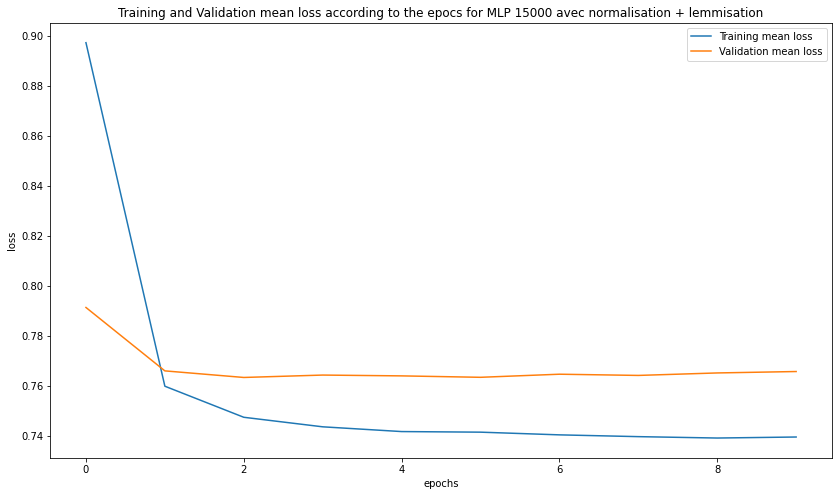

In [47]:
plt.figure(figsize = [14, 8])
plt.plot(range(n_epochs), t_losses, label = "Training mean loss")
plt.plot(range(n_epochs), v_losses, label = "Validation mean loss")
plt.title("Training and Validation mean loss according to the epocs for MLP 15000 avec normalisation + lemmisation")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

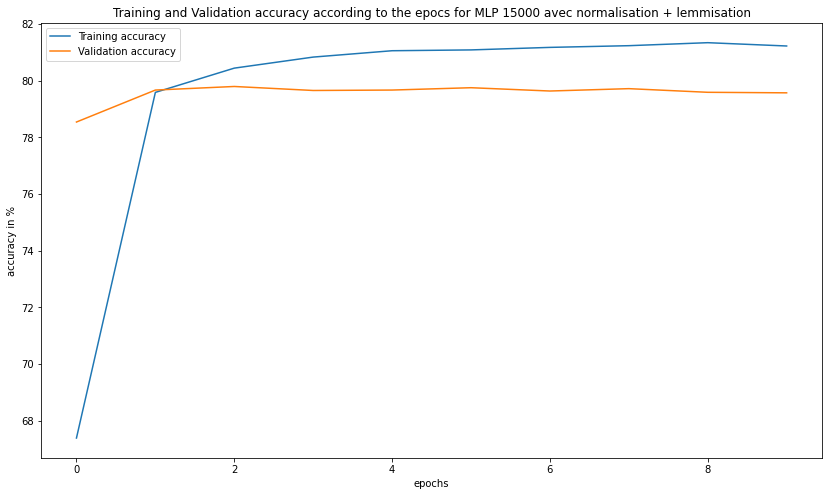

In [48]:
plt.figure(figsize = [14, 8])
plt.plot(range(n_epochs), np.array(t_accs) * 100, label = "Training accuracy")
plt.plot(range(n_epochs), np.array(v_accs) * 100, label = "Validation accuracy")
plt.title("Training and Validation accuracy according to the epocs for MLP 15000 avec normalisation + lemmisation")
plt.xlabel("epochs")
plt.ylabel("accuracy in %")
plt.legend()
plt.show()